In [85]:
import os
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#displaying numbers instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#for creating wordcloud
from wordcloud import WordCloud, STOPWORDS

In [22]:
#import the surveys
df = pd.read_csv('visit_survey.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 8 columns):
Unnamed: 0        67 non-null object
Unnamed: 1        661 non-null object
Unnamed: 2        143 non-null object
Unnamed: 3        85 non-null object
Unnamed: 4        120 non-null object
Survey Results    61 non-null object
Unnamed: 6        31 non-null object
Unnamed: 7        31 non-null object
dtypes: object(8)
memory usage: 61.2+ KB


## Clean Reviews for Text Analysis

In [45]:
#take reviews out of csv
reviews = pd.DataFrame(df.iloc[:, 1]).dropna().rename(columns = {'Unnamed: 1':'reviews'}).reset_index(drop = True)
reviews.head(20)

reviews
0   Time Period:                                                                                                                                                                                                         
1   Location(s):                                                                                                                                                                                                         
2   Provider(s):                                                                                                                                                                                                         
3   Appt Type(s):                                                                                                                                                                                                        
4   Survey Results: 1947 Responses, 24197 Sent, 8% Response Rate (1947/24197)                                                                                                                                            
5   Time Period:                                                                                                                                                                                                         
6   Location(s):                                                                                                                                                                                                         
7   Provider(s):                                                                                                                                                                                                         
8   Appt Type(s):                                                                                                                                                                                                        
9   Survey Results: 1947 Responses, 24197 Sent, 8% Response Rate (1947/24197)                                                                                                                                            
10  Time Period:                                                                                                                                                                                                         
11  Location(s):                                                                                                                                                                                                         
12  Provider(s):                                                                                                                                                                                                         
13  Appt Type(s):                                                                                                                                                                                                        
14  Survey Results: 1947 Responses, 24197 Sent, 8% Response Rate (1947/24197)                                                                                                                                            
15  Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better. If you would like to be contacted, please leave your name and phone number.
16                                                                                                                                                                                                                       
17  07/03/2018 - Front desk and check out staff are not nearly as nice as the professionals in the back. Check out lady acts like she doesn?t want to wait on you.                                                       
18  07/03/2018 - Complete attention & care. More than expected!!    

In [46]:
#cut out first few rows that don't hold any info
reviews = reviews.iloc[15:, :].reset_index(drop = True)
reviews.head(20)

reviews
0   Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better. If you would like to be contacted, please leave your name and phone number.                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2   07/03/2018 - Front desk and check out staff are not nearly as nice as the professionals in the back. Check out lady acts like she doesn?t want to wait on you.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3   07/03/2018 - Complete attention & care. More than expected!!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
4   07/03/2018 - My doctor, Dr. Walcott was very professional and kind. All the employees that took care of me were very professional and efficient                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
5   07/03/2018 - All is great                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [47]:
#extract dates from text and make them the index
# (?P<Date>....) - named capturing group
# \d+ 1 or more digits
# (?:\/\d+){2} - non-capturing group repeating twice, where
# \/ - escaped forward slash
# {2} - repeater (two times)
reviews.index = reviews.reviews.str.extract(r'(?P<Date>\d+(?:\/\d+){2})', expand=False).apply(pd.to_datetime)

In [48]:
reviews.head()

reviews
Date                                                                                                                                                                                                                             
NaT         Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better. If you would like to be contacted, please leave your name and phone number.
NaT                                                                                                                                                                                                                              
2018-07-03  07/03/2018 - Front desk and check out staff are not nearly as nice as the professionals in the back. Check out lady acts like she doesn?t want to wait on you.                                                       
2018-07-03  07/03/2018 - Complete attention & care. More than expected!!                                                                                                                                                         
2018-07-03  07/03/2018 - My doctor, Dr. Walcott was very professional and kind. All the employees that took care of me were very professional and efficient

In [63]:
#remove dates and symbols from reviews with regex, strip all white space
reviews['reviews'].replace(regex=True,inplace = True, to_replace=r'\d|\W',value=r' ')

In [67]:
#strip all whitespace to the left of the text, created through removing dates from reviews
reviews['reviews'] = reviews.reviews.str.lstrip()

In [68]:
reviews.head()

reviews
Date                                                                                                                                                                                                                             
NaT         Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better  If you would like to be contacted  please leave your name and phone number 
NaT                                                                                                                                                                                                                              
2018-07-03  Front desk and check out staff are not nearly as nice as the professionals in the back  Check out lady acts like she doesn t want to wait on you                                                                     
2018-07-03  Complete attention   care  More than expected                                                                                                                                                                        
2018-07-03  My doctor  Dr  Walcott was very professional and kind  All the employees that took care of me were very professional and efficient

## Generating A Wordcloud From Reviews
- __Here I am going to create an overall wordcloud to see what the most common words are from the reviews__
- __While this will show the common words, it will not reflect the negative reviews most likely since those are mentioned less, so I want to parse those out eventually using sentiment analysis__
- __I should probably also look into removing specific words, like "Dr." so that the wordcloud doesn't have to waste space with these, it is essentially a stop word here__

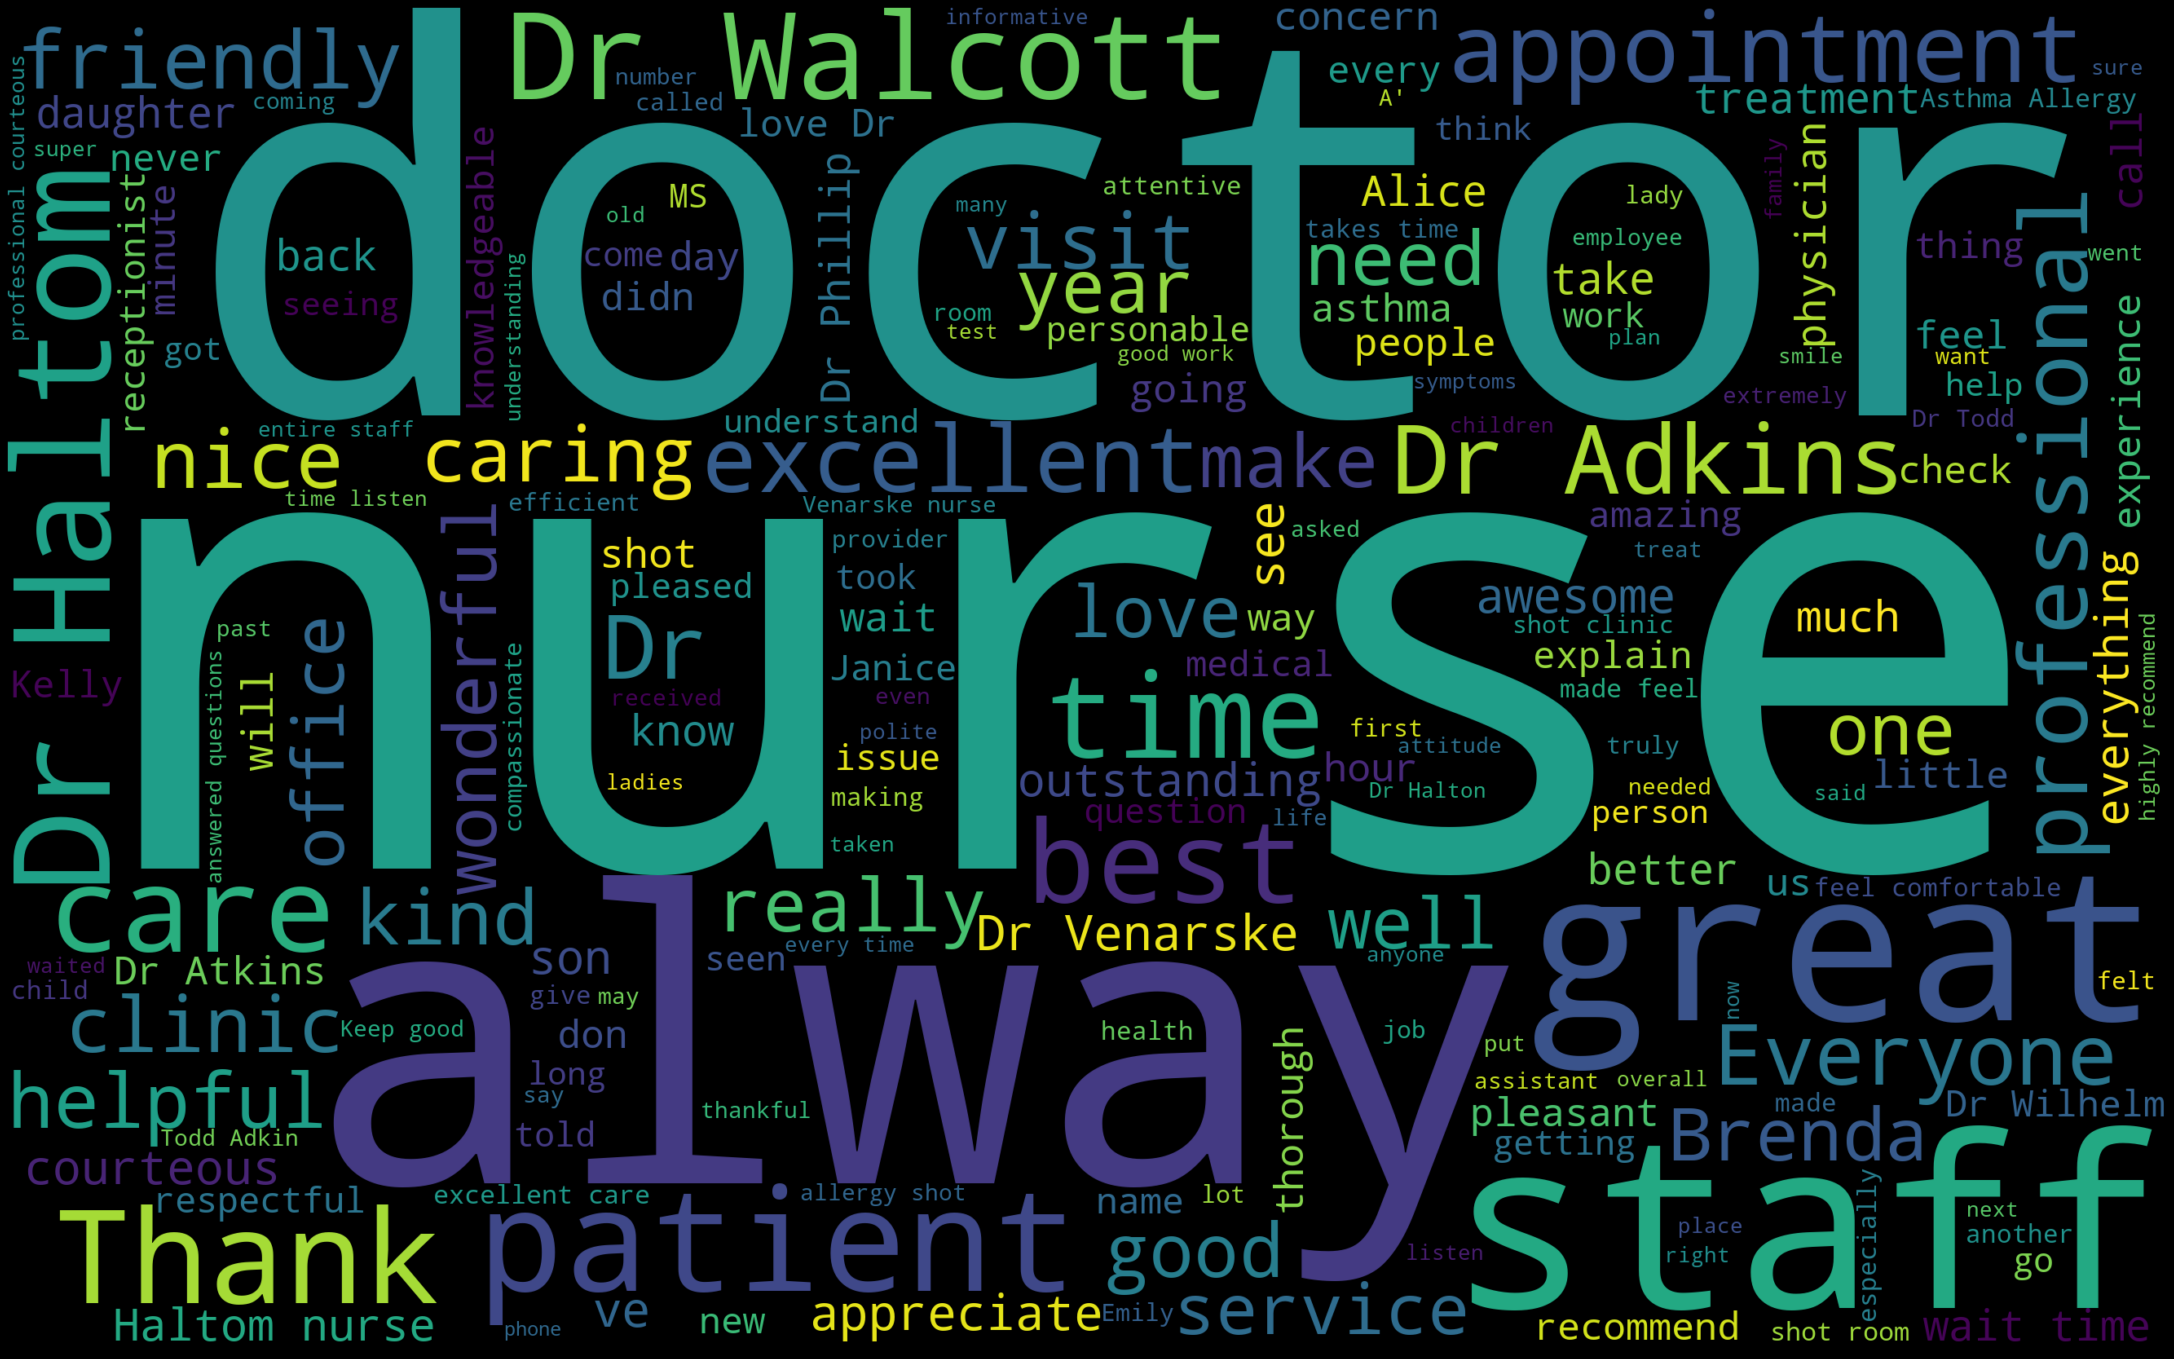

In [90]:
text = reviews.reviews.values
wordcloud = WordCloud(
    width = 2650,
    height = 1650,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

In [99]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews['tidy_reviews'] = reviews['reviews'].apply(lambda x: clean_text(x))

In [100]:
reviews.head()

reviews                                                                                                                                  tidy_reviews
Date                                                                                                                                                                                                                                                                                                                                                                           
NaT         Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better  If you would like to be contacted  please leave your name and phone number   please let know would like recognize outstanding service employee anything could do well would like contacted please leave name phone number
NaT                                                                                                                                                                                                                                                                                                                                                                            
2018-07-03  Front desk and check out staff are not nearly as nice as the professionals in the back  Check out lady acts like she doesn t want to wait on you                                                                       front desk check staff nearly nice professional back check lady act like want wait                                                          
2018-07-03  Complete attention   care  More than expected                                                                                                                                                                          complete attention care expect                                                                                                              
2018-07-03  My doctor  Dr  Walcott was very professional and kind  All the employees that took care of me were very professional and efficient                                                                                     doctor dr walcott professional kind employee take care professional efficient

In [101]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews['sentiments'] = reviews['tidy_reviews'].apply(lambda x: sid.polarity_scores(x))
reviews = pd.concat([reviews.drop(['sentiments'], axis=1), reviews['sentiments'].apply(pd.Series)], axis=1)

In [102]:
reviews.head()

reviews                                                                                                                                  tidy_reviews  neg  neu  pos  compound
Date                                                                                                                                                                                                                                                                                                                                                                                                    
NaT         Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better  If you would like to be contacted  please leave your name and phone number   please let know would like recognize outstanding service employee anything could do well would like contacted please leave name phone number 0.04 0.42 0.55 0.93     
NaT                                                                                                                                                                                                                                                                                                                                                                             0.00 0.00 0.00 0.00     
2018-07-03  Front desk and check out staff are not nearly as nice as the professionals in the back  Check out lady acts like she doesn t want to wait on you                                                                       front desk check staff nearly nice professional back check lady act like want wait                                                           0.00 0.62 0.38 0.68     
2018-07-03  Complete attention   care  More than expected                                                                                                                                                                          complete attention care expect                                                                                                               0.00 0.48 0.52 0.49     
2018-07-03  My doctor  Dr  Walcott was very professional and kind  All the employees that took care of me were very professional and efficient                                                                                     doctor dr walcott professional kind employee take care professional efficient                                                                0.00 0.43 0.57 0.86

### Bathroom Reviews
- looking into this at the request of the CEO

In [122]:
reviews[reviews['reviews'].str.contains('bathroom|restroom|Bathroom|Restroom|clean')]

reviews                                                                                                                                                                                                                                                                   tidy_reviews  neg  neu  pos  compound
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2018-12-28  Dr Phillips is truly a gifted physician displaying medical knowledge along with genuine compassion for mankind  His staff the ladies in the front  his nurses along with the lady in scheduling are extremely professional  This is the best office staff I have ever experienced  The buildings itself though especially the ladies room outside the office is never clean or well kept            dr phillips truly gift physician display medical knowledge along genuine compassion mankind staff ladies front nurse along lady schedule extremely professional best office staff ever experience building though especially ladies room outside office never clean well keep 0.08 0.64 0.28 0.88     
2019-02-15  This was an amazing experience  I left hopeful and reassured  Everything was excellent  I marked cleanliness as  good  because the room  especially the framed pictures  were pretty dusty                                                                                                                                                                                                          amaze experience leave hopeful reassure everything excellent mark cleanliness good room especially frame picture pretty dusty                                                                                                                                                 0.04 0.30 0.65 0.96     
2019-05-07  Alice  Dr  Venarske s nurse and all the shot room workers are outstanding in their concern  courtesy  friendliness  knowledge  professionalism  and service  The restrooms are not clean  Generally there is litter on the floors  They do not inspire confidence                                                                                                                                   alice dr venarske nurse shot room worker outstanding concern courtesy friendliness knowledge professionalism service restroom clean generally litter floor inspire confidence                                                                                                 0.00 0.44 0.56 0.96     
2019-06-09  Bathrooms cleaned with hand sanitizer in there and kids magazines in the waiting area and stuff a little more friendly                                                                                                                                                                                                                                                                              bathroom clean hand sanitizer kid magazine wait area stuff little friendly                                                                                                                                                                                                    0.00 0.48 0.52 0.83     
2019-06-28  The restrooms could have been much cleaner  As far as doctors go Dr Philips is at the pinnacle of professionalism and   expertise   He has literally cured me of chronic hives and greatly improved my quality of

## Separating Negative From Positive Reviews

In [179]:
negative_reviews = reviews[reviews['neg'] > .2] 

In [180]:
negative_reviews.shape

(33, 6)

In [181]:
negative_reviews.head()

reviews                                                                                                                                                                                                            tidy_reviews  neg  neu  pos  compound
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2018-07-11  Nothing everyone was so nice n friendly they were caring n polite all n all they were excellent I give them a    Thank y all for my care                                                                                                                                                                                                                                                        nothing everyone nice friendly care polite excellent give thank care                                                                                                                                                   0.23 0.19 0.58 0.82     
2018-07-06  Everyone I ve ever had to deal with has been so nice  I ve yet to have a bad experience after several years of using MSAAC                                                                                                                                                                                                                                                                      everyone ever deal nice yet bad experience several year use msaac                                                                                                                                                      0.23 0.59 0.18 -0.18    
2018-09-26  I love this clinic and Dr  Atkins and staff are awesome  And I will like to thank  Dr  Wilhelm for helping me while Dr  Atkins was out  I was having trouble breathing and I was terrified  I thought if I got my shot I would be ok  Instead they saw I was in the middle of a attack and gave me a treatment instead  I will recommend this clinic to everyone  Thanks again for everything   love clinic dr atkins staff awesome like thank dr wilhelm help dr atkins trouble breathe terrify think got shoot would ok instead saw middle attack give treatment instead recommend clinic everyone thanks everything 0.20 0.37 0.42 0.90     
2018-10-17  Dr  Forgot to look in my ears and I remarked that I was having a little discomfort                                                                                                                                                                                                                                                                                                              dr forget look ear remark little discomfort                                                                                                                                                                            0.47 0.53 0.00 -0.53    
2018-10-24  I made the appointment only the day before I was seen  In spite of that I had a very short wait time and efficient service by the young lady taking the preliminary information and by Dr  Adkins   going so far as to give me a dose of medicine in the office because I felt so bad                                                                                                           make appointment day see spite short wait time efficient service young lady take preliminary information dr adkins go far give dose medicine office felt bad                   

## Positive Review Wordcloud

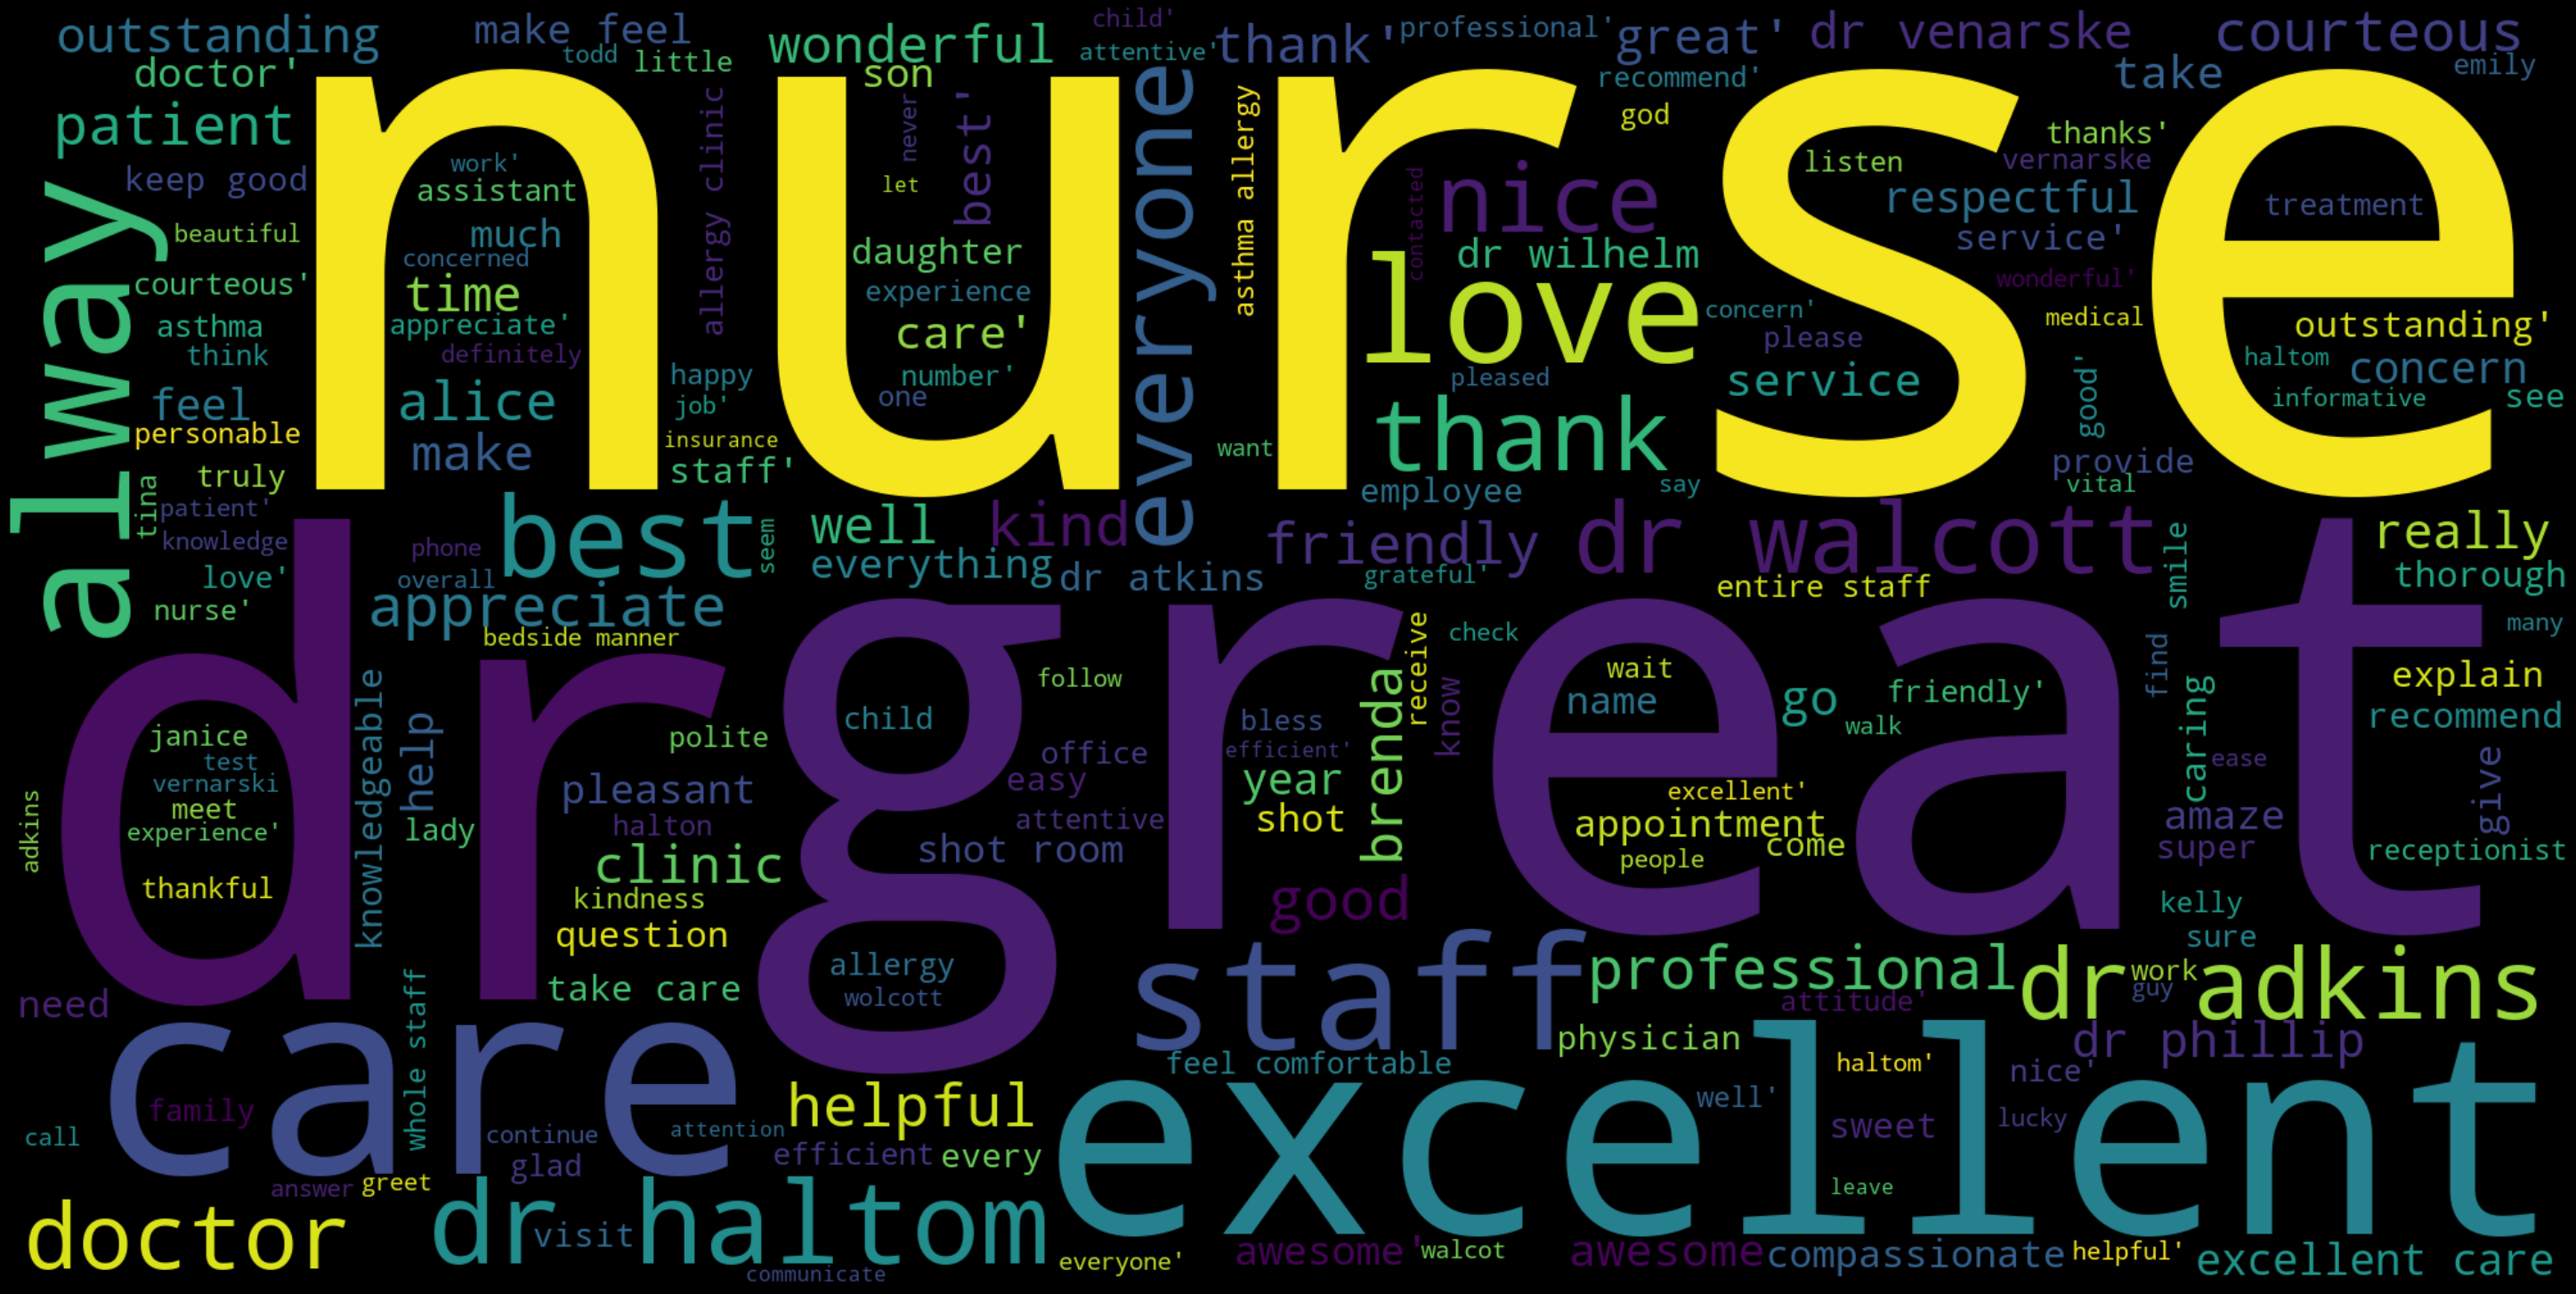

In [171]:
text = reviews[reviews['pos'] > .5]['tidy_reviews'].values
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

### Negative Review Wordcloud

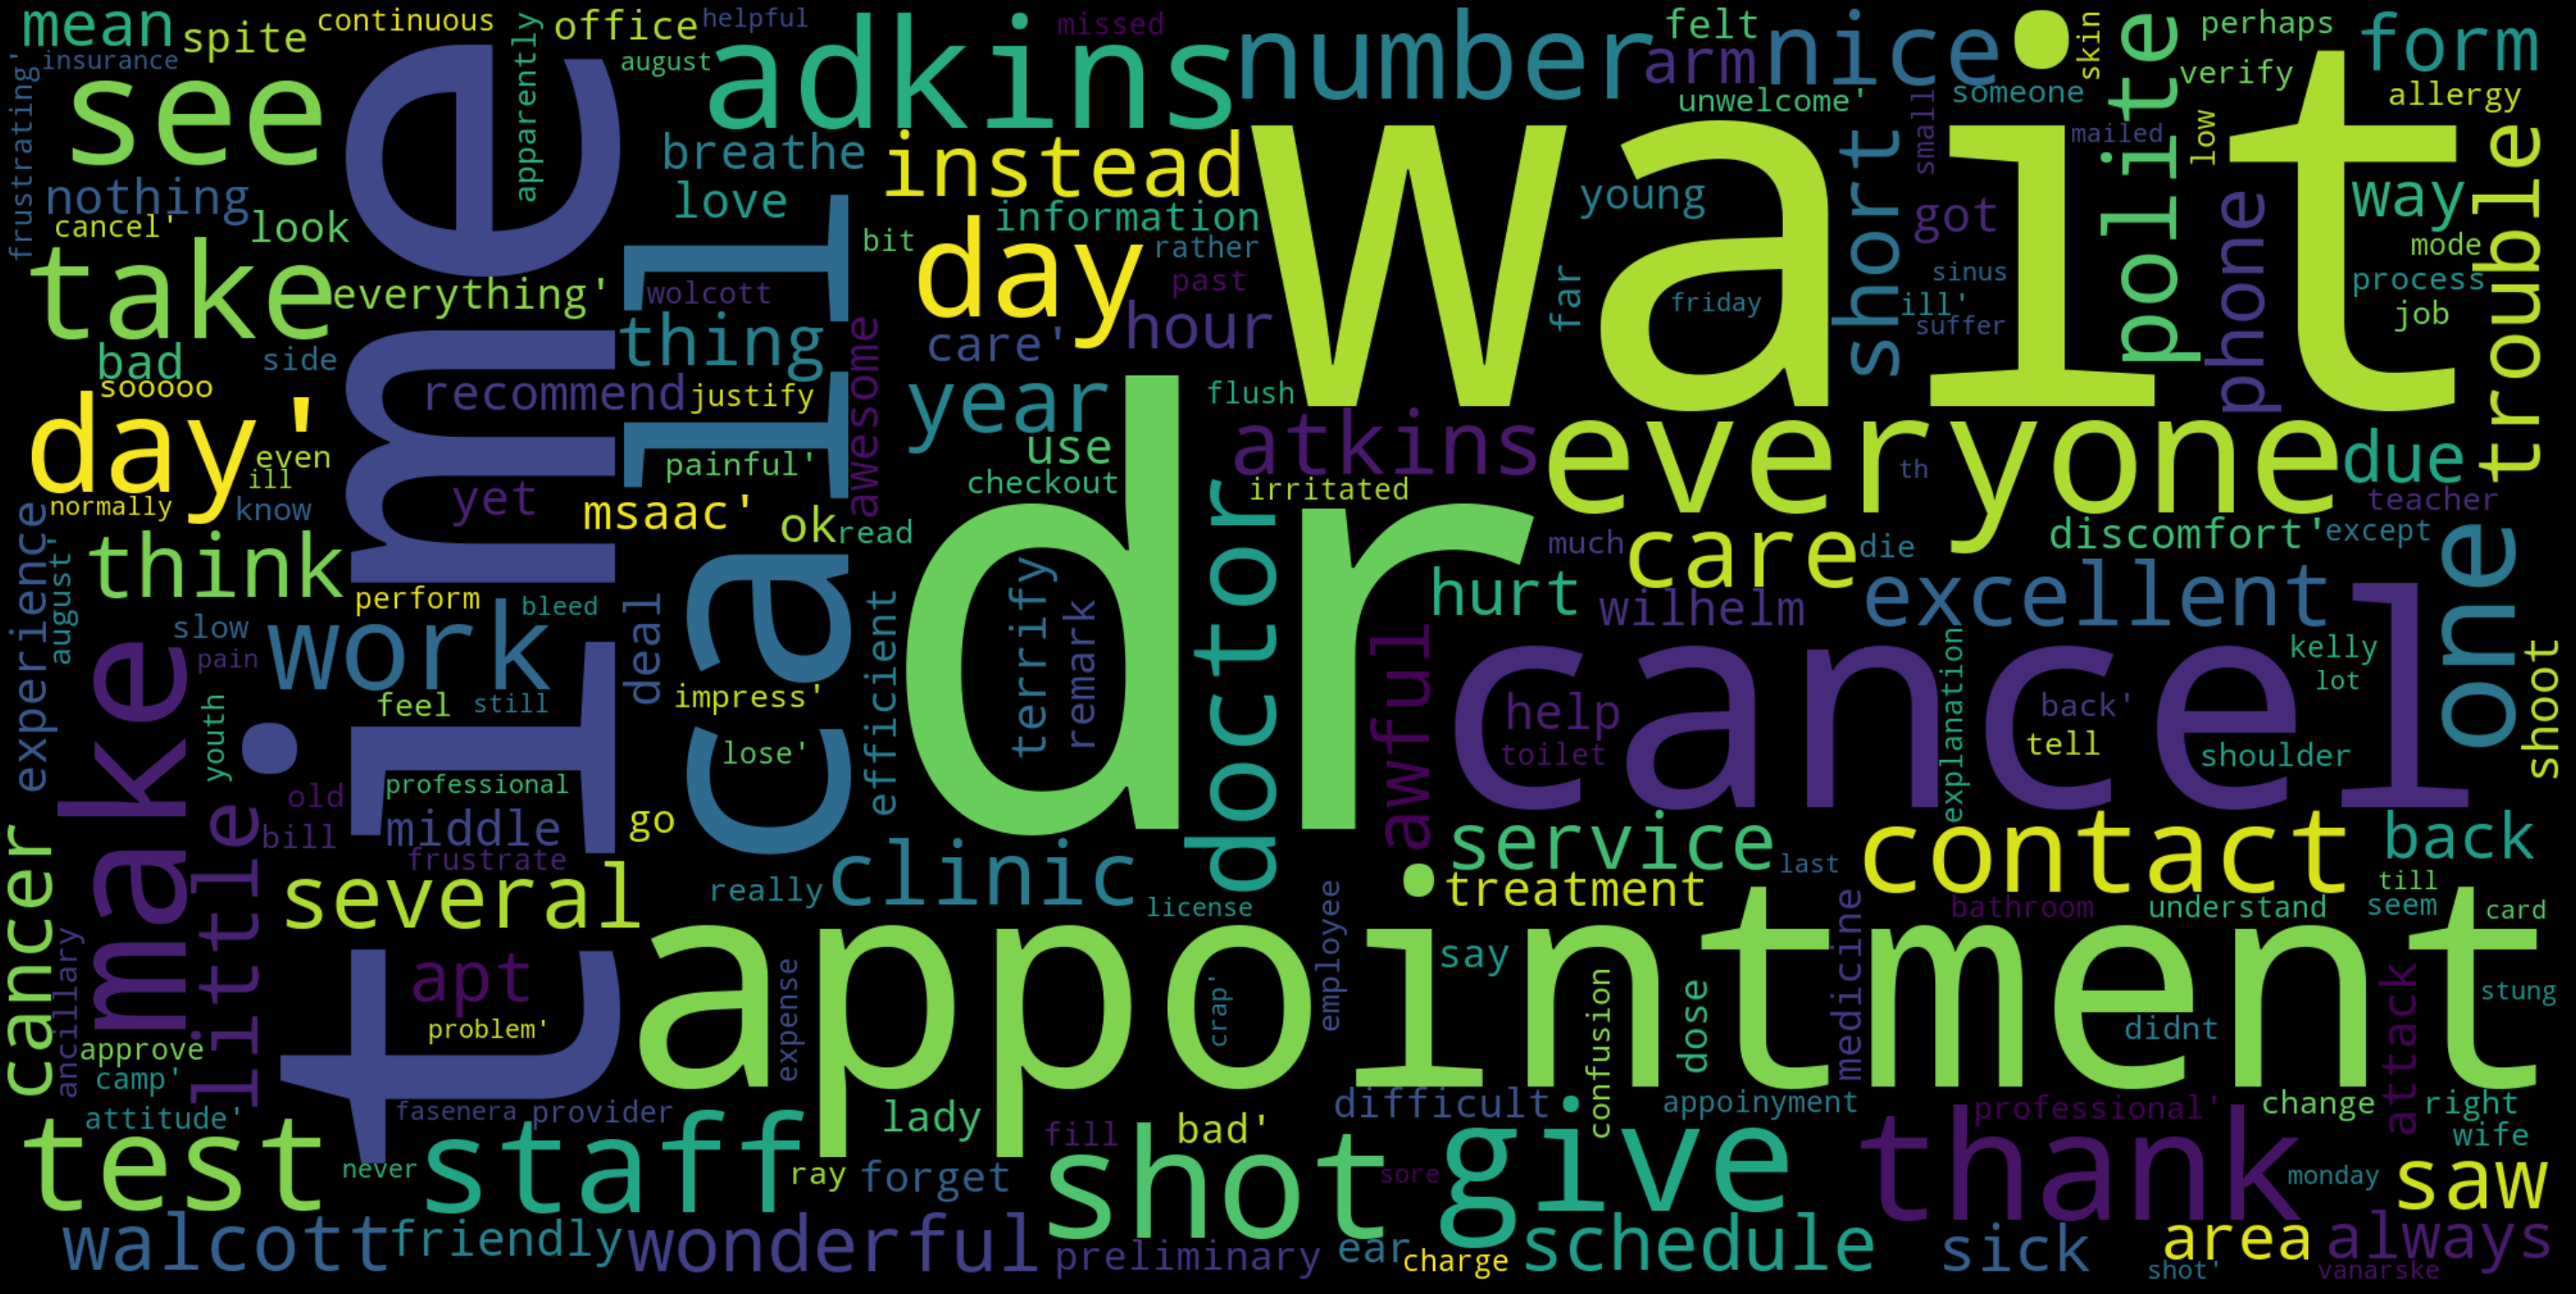

In [173]:
text = reviews[reviews['neg'] > .2]['tidy_reviews'].values
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

### Looking at Sentiment Analysis for Non-Tidy Reviews
- __Leaving in stop words to see if the sentiment analyzer captures sentiment differently with them in__

In [184]:
reviews['raw_sentiments'] = reviews['reviews'].apply(lambda x: sid.polarity_scores(x))
reviews = pd.concat([reviews.drop(['raw_sentiments'], axis=1), reviews['raw_sentiments'].apply(pd.Series)], axis=1)

In [204]:
reviews.columns

Index(['reviews', 'tidy_reviews', 'neg', 'neu', 'pos', 'compound', 'neg', 'neu', 'pos', 'compound'], dtype='object')

In [205]:
#rename columns
reviews.columns = ['reviews', 'tidy_reviews', 'neg', 'neu', 'pos', 'compound', 'raw_neg', 'raw_neu', 'raw_pos', 'raw_compound']

In [206]:
reviews.head()

reviews                                                                                                                                  tidy_reviews  neg  neu  pos  compound  raw_neg  raw_neu  raw_pos  raw_compound
Date                                                                                                                                                                                                                                                                                                                                                                                                                                             
NaT         Please let us know if you would like to recognize outstanding service from an employee or if there is anything we could have done better  If you would like to be contacted  please leave your name and phone number   please let know would like recognize outstanding service employee anything could do well would like contacted please leave name phone number 0.04 0.42 0.55 0.93      0.02     0.62     0.36     0.94         
NaT                                                                                                                                                                                                                                                                                                                                                                             0.00 0.00 0.00 0.00      0.00     0.00     0.00     0.00         
2018-07-03  Front desk and check out staff are not nearly as nice as the professionals in the back  Check out lady acts like she doesn t want to wait on you                                                                       front desk check staff nearly nice professional back check lady act like want wait                                                           0.00 0.62 0.38 0.68      0.07     0.81     0.12     0.12         
2018-07-03  Complete attention   care  More than expected                                                                                                                                                                          complete attention care expect                                                                                                               0.00 0.48 0.52 0.49      0.00     0.61     0.39     0.49         
2018-07-03  My doctor  Dr  Walcott was very professional and kind  All the employees that took care of me were very professional and efficient                                                                                     doctor dr walcott professional kind employee take care professional efficient                                                                0.00 0.43 0.57 0.86      0.00     0.66     0.34     0.87

In [212]:
#there don't seem to be too many bad reviews, thats good if the people who are unsatisfied are actually taking the survey
negative_reviews_raw = reviews[reviews['raw_neg'] > .2]
negative_reviews_raw.shape
negative_reviews_raw

(18, 10)

reviews                                                                                                                                tidy_reviews  neg  neu  pos  compound  raw_neg  raw_neu  raw_pos  raw_compound
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2018-11-07  Difficult to say as all were very polite and professional                                                                                                                                                                                   difficult say polite professional                                                                                                          0.46 0.55 0.00 -0.36     0.22     0.78     0.00     -0.36        
2018-11-16  I thought the teacher was too low for the allergy test because I m so short and my shoulders were really painful                                                                                                                            think teacher low allergy test short shoulder really painful                                                                               0.43 0.57 0.00 -0.65     0.24     0.76     0.00     -0.65        
2018-11-16  No Thanks                                                                                                                                                                                                                                   thanks                                                                                                                                     0.00 0.00 1.00 0.44      0.43     0.00     0.57     0.18         
2018-12-04  Walcott s did an excellent job X ray and verifying no cancer in right side  Tell him I was impressed                                                                                                                                        walcott excellent job ray verify cancer right side tell impress                                                                            0.24 0.39 0.37 0.30      0.25     0.49     0.26     0.05         
2018-12-12  One employee made me feel unwelcome                                                                                                                                                                                                         one employee make feel unwelcome                                                                                                           0.40 0.60 0.00 -0.40     0.35     0.65     0.00     -0.40        
2019-01-09  Dr  Walcott is wonderful  Ancillary staff  not so much  Some confusion with billing  Wait time was awful    perhaps just the day                                                                                                            dr walcott wonderful ancillary staff much confusion bill wait time awful perhaps day                                                       0.28 0.53 0.20 -0.13     0.20     0.66     0.14     -0.19        
2019-02-01  Yeah  stop my vasomotor rhinitis  It s driving me nuts  J Richard Pratt  PhD              Please do not contact                                                                                                                             yeah stop vasomotor rhinitis drive nut richard pratt phd please contact                                                                    0.15 0.54 0.31 0.32      0.21     0.57     0.21     0.00         
2019-02-11  Appoinyment was cancelled                                                                                                                             

## Topic Modeling and Clustering For Positive Reviews

In [370]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#choosing n-gram range here, we can change this to see how the data reacts
count_vectorizer = CountVectorizer(ngram_range=(1, 4),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6, max_features=4000)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6, max_features=4000)

cv_data = count_vectorizer.fit_transform(reviews.tidy_reviews)
tfidf_data = tfidf_vectorizer.fit_transform(reviews.tidy_reviews)

In [371]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
# try using 5 topics
n_comp = 7
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_cv = TruncatedSVD(n_components=n_comp)
nmf_tfidf = NMF(n_components=n_comp)
nmf_cv = NMF(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
lsa_cv_data = lsa_cv.fit_transform(cv_data)
nmf_tfidf_data = nmf_tfidf.fit_transform(tfidf_data)
nmf_cv_data = nmf_cv.fit_transform(cv_data)

In [372]:
# def functions for topic modelings
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def display_topics2(model, feature_names, no_top_words=10, topic_names = None):
    for index, topic in enumerate(model.components_):
        if not topic_names or not topic_names[index]:
            print(f"\nTopic {index}")
        else:
            print(f"\nTopic {topic_names[index]}:")
        msg = ", ".join([f'{feature_names[i]} ({topic[i]:6.4f})' 
                             for i in topic.argsort()[:-no_top_words-1:-1]])
        print(msg)

In [373]:
# topic modeling with lsa and tfidf
display_topics2(lsa_tfidf, tfidf_vectorizer.get_feature_names(),8)


Topic 0
dr (0.4131), nurse (0.2816), haltom (0.2672), dr haltom (0.2587), dr walcott (0.2016), walcott (0.2012), great (0.1773), care (0.1659)

Topic 1
haltom (0.4260), dr haltom (0.4121), haltom nurse (0.2427), brenda (0.2195), brenda dr (0.1194), nurse brenda (0.1164), nurse (0.0975), love (0.0678)

Topic 2
dr walcott (0.4243), walcott (0.4223), love (0.1635), haltom (0.1449), dr haltom (0.1409), love dr (0.1017), dr (0.0984), walcott nurse (0.0899)

Topic 3
excellent (0.6505), excellent service (0.1797), service (0.1471), thanks (0.1448), excellent care (0.1021), care (0.0883), thank (0.0872), excellent staff (0.0735)

Topic 4
good (0.5870), good work (0.2035), work (0.1955), excellent (0.1524), time (0.1480), wait (0.1210), service (0.0987), excellent service (0.0840)

Topic 5
great (0.5475), excellent (0.3068), alice (0.2758), awesome (0.1424), dr venarske (0.1396), venarske (0.1391), excellent service (0.0937), job (0.0906)

Topic 6
good (0.3041), awesome (0.2574), dr venarske (

In [374]:
# topic modeling with lsa and countvectorizer
display_topics2(lsa_cv, count_vectorizer.get_feature_names(),10)


Topic 0
dr (0.6112), nurse (0.2968), care (0.1988), doctor (0.1884), time (0.1882), haltom (0.1831), dr haltom (0.1720), patient (0.1533), staff (0.1356), make (0.1273)

Topic 1
time (0.4312), wait (0.2826), prescription (0.2002), kroger (0.1993), appointment (0.1754), patient (0.1721), doctor (0.1452), ready (0.1329), ask (0.1216), tell (0.1206)

Topic 2
haltom (0.4097), dr haltom (0.3912), nurse (0.2173), haltom nurse (0.1575), dr haltom nurse (0.1461), prescription (0.1227), kroger (0.1222), brenda (0.1209), ready (0.0815), form (0.0617)

Topic 3
nurse (0.2429), prescription (0.2199), kroger (0.2189), dr (0.1758), ready (0.1460), form (0.1133), byram (0.1095), ask (0.1044), say (0.1009), adkins (0.0841)

Topic 4
walcott (0.2672), dr walcott (0.2662), haltom (0.2341), dr haltom (0.2269), clinic (0.1313), staff (0.1199), patient (0.1131), appointment (0.1049), professional (0.0843), brenda (0.0798)

Topic 5
doctor (0.4064), walcott (0.2900), dr walcott (0.2883), like (0.1399), care (

In [375]:
# topic modeling with nmf and tfidf
display_topics2(nmf_tfidf, tfidf_vectorizer.get_feature_names(),10)


Topic 0
dr walcott (1.4635), walcott (1.4600), dr (0.6688), walcott nurse (0.3152), love (0.2853), kelly (0.2831), nurse (0.1639), nurse kelly (0.1572), kelly dr (0.1562), love dr (0.1465)

Topic 1
haltom (0.8327), dr haltom (0.8063), haltom nurse (0.4540), dr (0.4144), brenda (0.3834), nurse (0.3832), love (0.3005), nurse brenda (0.2114), brenda dr (0.2099), love dr (0.2060)

Topic 2
adkins (0.8424), dr adkins (0.7943), dr (0.5188), time (0.4723), doctor (0.4227), staff (0.3856), helpful (0.2981), friendly (0.2946), professional (0.2626), wait (0.2614)

Topic 3
excellent (1.3221), excellent service (0.3614), service (0.3414), thanks (0.3167), care (0.2121), excellent care (0.2042), thank (0.1708), staff (0.1565), excellent staff (0.1412), excellent thank (0.0948)

Topic 4
good (1.2362), good work (0.4546), work (0.4143), outstanding (0.1815), phillips (0.1523), dr phillips (0.1406), brenda (0.1093), doctor (0.0893), good care (0.0826), emily (0.0797)

Topic 5
great (1.4300), job (0.1

In [376]:
# topic modeling with nmf and countvectorizer
display_topics2(nmf_cv, count_vectorizer.get_feature_names(),10)


Topic 0
staff (2.9725), great (2.2208), clinic (1.8720), shot (1.3689), allergy (1.2117), asthma (0.9384), patient (0.8320), professional (0.7633), courteous (0.6821), need (0.6375)

Topic 1
time (2.7981), doctor (1.9663), wait (1.7965), appointment (1.2511), wait time (0.7489), patient (0.7381), long (0.5731), visit (0.5594), minute (0.5449), make (0.4993)

Topic 2
haltom (2.6597), dr haltom (2.5247), dr (2.3535), brenda (0.7370), haltom nurse (0.7108), dr haltom nurse (0.6572), doctor (0.4478), love (0.3880), like (0.3166), recommend (0.3035)

Topic 3
prescription (1.4542), kroger (1.4479), ready (0.9653), ask (0.7815), say (0.7696), form (0.7533), time (0.7520), byram (0.7239), patient (0.6441), know (0.5634)

Topic 4
dr (2.6508), adkins (1.9327), dr adkins (1.7826), best (0.5637), helpful (0.3744), doctor (0.3555), explain (0.3047), know (0.2697), adkins nurse (0.2440), care (0.2323)

Topic 5
dr (2.2646), walcott (2.1091), dr walcott (2.1019), care (0.6513), professional (0.4457),

In [377]:
terms = tfidf_vectorizer.get_feature_names()

for i in range(0,7):
    word_list=[]
    print("Topic%d:"% i)
    for j in lsa_tfidf.components_.argsort()[i, -16:-1]:
        word_list.append(terms[j])
    print(word_list)

Topic0:
['time', 'best', 'adkins', 'doctor', 'haltom nurse', 'excellent', 'staff', 'love', 'care', 'great', 'walcott', 'dr walcott', 'dr haltom', 'haltom', 'nurse']
Topic1:
['janice', 'amaze love', 'brenda janice', 'best', 'haltom great', 'haltom staff', 'love dr', 'haltom best', 'love', 'nurse', 'nurse brenda', 'brenda dr', 'brenda', 'haltom nurse', 'dr haltom']
Topic2:
['walcott best', 'brenda dr', 'walcott awesome', 'nurse brenda', 'kelly dr', 'brenda', 'kelly', 'haltom nurse', 'walcott nurse', 'dr', 'love dr', 'dr haltom', 'haltom', 'love', 'walcott']
Topic3:
['staff excellent', 'entire staff', 'excellent thank', 'dr haltom', 'haltom', 'dr walcott', 'walcott', 'staff', 'excellent staff', 'thank', 'care', 'excellent care', 'thanks', 'service', 'excellent service']
Topic4:
['doctor', 'care', 'phillips', 'wait time', 'thank', 'appointment', 'brenda', 'outstanding', 'excellent service', 'service', 'wait', 'time', 'excellent', 'work', 'good work']
Topic5:
['kelly', 'venarske awesome', '

In [378]:
# initialize standardscaler
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()

# transform my reducer data using standardscaler
lsa_tfidf_data_scaled = SS.fit_transform(lsa_tfidf_data)
lsa_cv_data_scaled = SS.fit_transform(lsa_cv_data)
nmf_tfidf_data_scaled = SS.fit_transform(nmf_tfidf_data)
nmf_cv_data_scaled = SS.fit_transform(nmf_cv_data)

In [379]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(lsa_tfidf_data_scaled)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_tfidf_data_scaled, labels, metric='euclidean'))
    SSEs.append(km.inertia_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

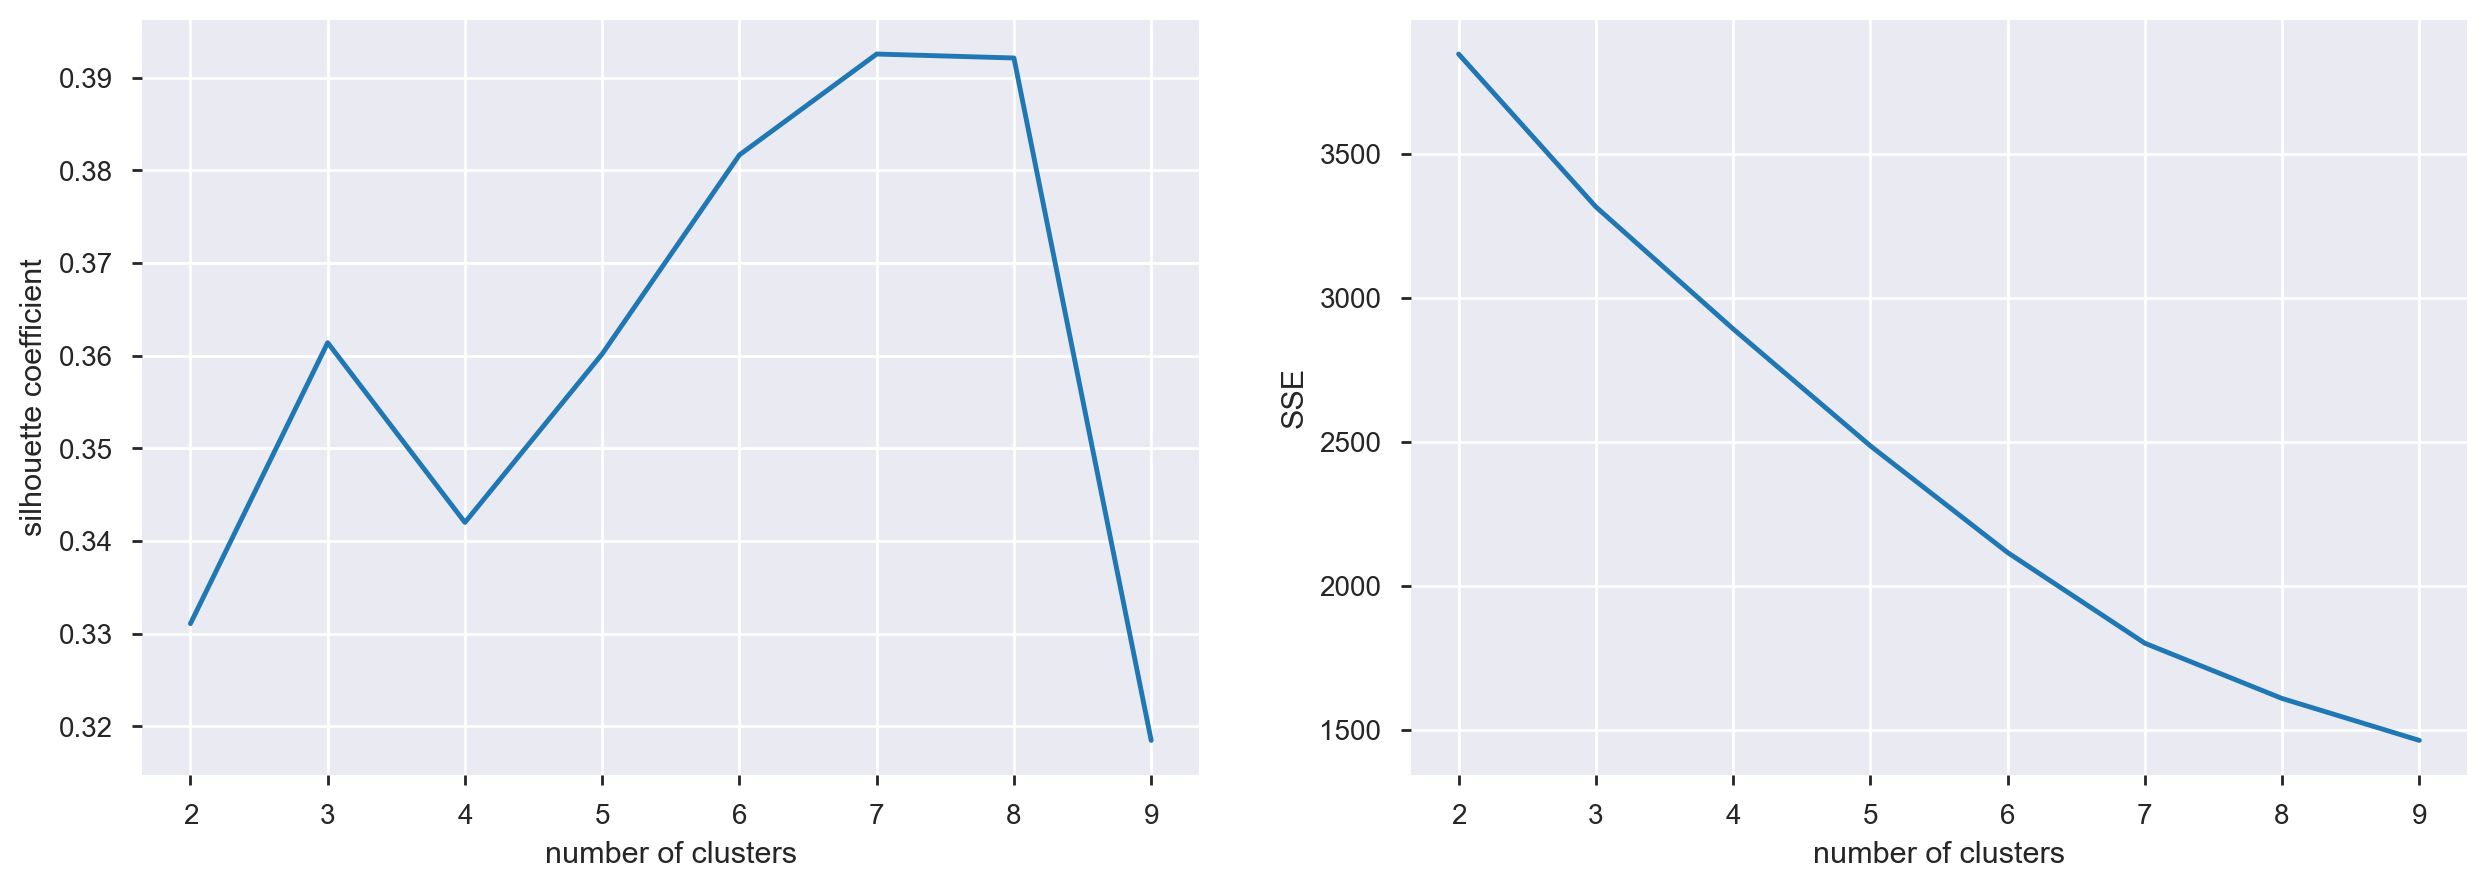

In [380]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [381]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(lsa_tfidf_data_scaled)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  2   Inertia: 3845.332040


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  3   Inertia: 3315.026453


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  4   Inertia: 2892.283420


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  5   Inertia: 2485.276681


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  6   Inertia: 2112.735891


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  7   Inertia: 1800.898299


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  8   Inertia: 1609.001402


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  9   Inertia: 1462.048708


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 10   Inertia: 1366.037866


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 11   Inertia: 1276.035121


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 12   Inertia: 1181.663389


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 13   Inertia: 1096.873424


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=14, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 14   Inertia: 1048.346135


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 15   Inertia: 992.987202


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 16   Inertia: 925.303873


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=17, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 17   Inertia: 888.287844


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=18, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 18   Inertia: 855.926531


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=19, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 19   Inertia: 811.984761


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 20   Inertia: 793.154286


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=21, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 21   Inertia: 760.779011


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=22, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 22   Inertia: 743.210800


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=23, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 23   Inertia: 712.918777


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=24, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 24   Inertia: 681.071380


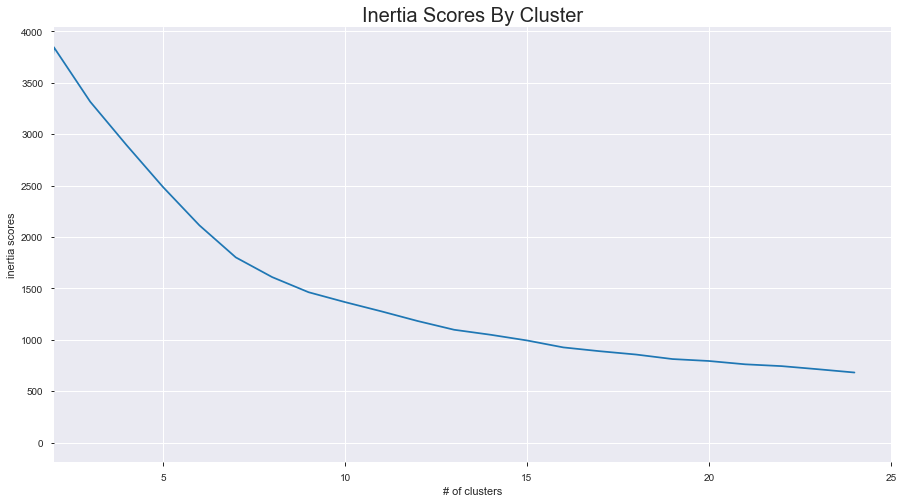

In [382]:
plt.figure(figsize=(15,8))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.title('Inertia Scores By Cluster', fontsize = 20);

In [383]:
# running clusters with 8 since that was the highest silhouette score
k = 8
kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(lsa_tfidf_data_scaled)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = tfidf_vectorizer.get_feature_names()

for i in range(0,k):
    word_list=[]
    print("cluster%d:"% i)
    for j in centers[i,:15]:
        word_list.append(terms[j])
    print(word_list)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

cluster0:
['accommodate', 'absolutely', 'absolutely love', 'accept', 'action', 'act', 'able']
cluster1:
['absolutely love', 'able', 'accept', 'accommodate', 'act', 'action', 'absolutely']
cluster2:
['absolutely', 'able', 'absolutely love', 'accept', 'act', 'accommodate', 'action']
cluster3:
['accept', 'act', 'accommodate', 'able', 'action', 'absolutely', 'absolutely love']
cluster4:
['action', 'able', 'accept', 'absolutely', 'absolutely love', 'act', 'accommodate']
cluster5:
['accommodate', 'action', 'absolutely', 'able', 'absolutely love', 'act', 'accept']
cluster6:
['act', 'able', 'absolutely', 'accommodate', 'absolutely love', 'action', 'accept']
cluster7:
['action', 'act', 'able', 'accommodate', 'absolutely', 'absolutely love', 'accept']


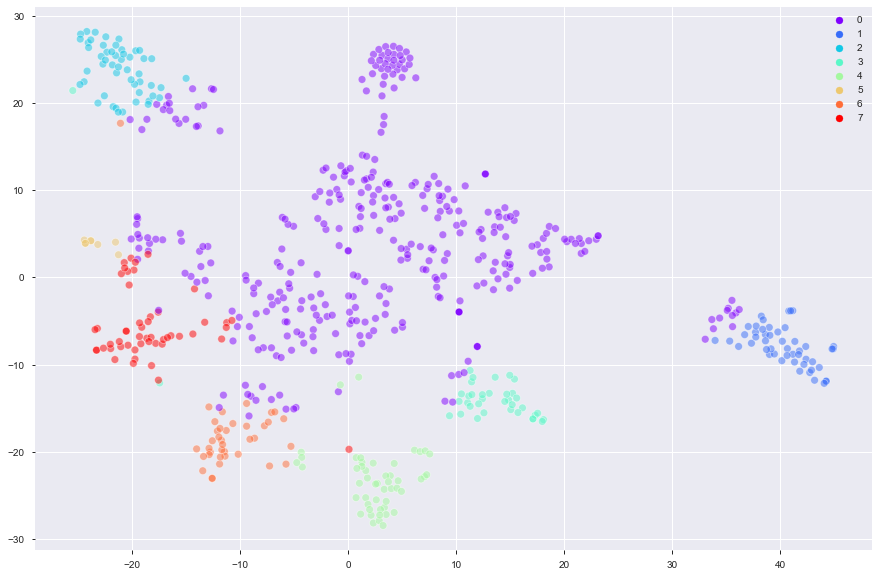

In [386]:
from sklearn.manifold import TSNE
#tsne = TSNE(n_components=2, verbose=1, perplexity=92, n_iter=300)
tsne = TSNE()
X_ne = tsne.fit_transform(lsa_tfidf_data_scaled)

plt.figure(figsize=(15,10))
sns.scatterplot(X_ne[:, 0], X_ne[:, 1], hue=kmeans.labels_, alpha=0.5, s = 60, palette='rainbow', legend='full');

In [348]:
for i in range(0,k):
    word_list=[]
    print("cluster%d:"% i)
    for j in centers[i,:15]:
        word_list.append(terms[j])
    print(word_list)

cluster0:
['absolutely love', 'able', 'accept', 'accommodate', 'act', 'action', 'absolutely']
cluster1:
['accommodate', 'absolutely', 'absolutely love', 'accept', 'action', 'act', 'able']
cluster2:
['accept', 'act', 'accommodate', 'able', 'action', 'absolutely', 'absolutely love']
cluster3:
['act', 'able', 'absolutely', 'accommodate', 'absolutely love', 'action', 'accept']
cluster4:
['action', 'act', 'accommodate', 'able', 'absolutely', 'absolutely love', 'accept']
cluster5:
['action', 'able', 'accept', 'absolutely', 'absolutely love', 'act', 'accommodate']
cluster6:
['accommodate', 'action', 'absolutely', 'able', 'absolutely love', 'act', 'accept']
cluster7:
['absolutely', 'able', 'absolutely love', 'accept', 'act', 'accommodate', 'action']


In [349]:
kmeans.labels_

array([1, 1, 1, 1, 0, 3, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 4, 1, 4, 5, 1,
       1, 4, 1, 1, 7, 1, 5, 4, 7, 5, 7, 0, 1, 2, 1, 5, 1, 1, 0, 1, 1, 4,
       1, 1, 1, 5, 2, 1, 1, 1, 4, 1, 7, 1, 1, 1, 1, 2, 4, 4, 2, 1, 1, 4,
       1, 0, 7, 2, 2, 1, 3, 1, 1, 1, 1, 1, 3, 4, 7, 1, 6, 1, 1, 5, 1, 3,
       1, 4, 1, 7, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 7, 1, 1, 1,
       1, 5, 1, 1, 2, 4, 1, 1, 1, 3, 2, 1, 4, 1, 1, 5, 0, 5, 1, 1, 4, 4,
       0, 1, 4, 5, 1, 5, 1, 3, 4, 1, 1, 1, 1, 7, 1, 1, 1, 3, 1, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 5, 7, 1, 1, 2, 2, 1, 3, 2, 1, 1,
       1, 1, 4, 0, 2, 1, 7, 1, 1, 0, 4, 7, 0, 4, 1, 2, 0, 0, 1, 1, 5, 4,
       5, 6, 7, 3, 0, 5, 7, 1, 7, 1, 1, 1, 5, 0, 4, 5, 7, 1, 7, 7, 0, 5,
       1, 1, 3, 5, 4, 4, 3, 1, 1, 1, 1, 1, 5, 1, 1, 1, 0, 1, 2, 0, 1, 2,
       1, 7, 1, 5, 1, 1, 2, 1, 2, 7, 0, 3, 1, 1, 1, 0, 0, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 7, 1, 1, 0, 0, 1, 5, 1, 1, 1, 1, 0, 1, 1, 7, 3, 0,
       2, 6, 1, 1, 7, 1, 5, 1, 3, 1, 1, 1, 1, 1, 2,

In [350]:
reviews['preliminary_cluster_labels'] = kmeans.labels_

In [369]:
reviews[reviews['preliminary_cluster_labels'] == 1]

reviews                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             tidy_reviews  neg  neu  pos  compound  raw_neg  raw_neu  raw_pos  raw_compound  preliminary_cluster_labels
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Now Clustering Using NMF_TFIDF

In [296]:
SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(nmf_tfidf_data_scaled)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(nmf_tfidf_data_scaled, labels, metric='euclidean'))
    SSEs.append(km.inertia_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

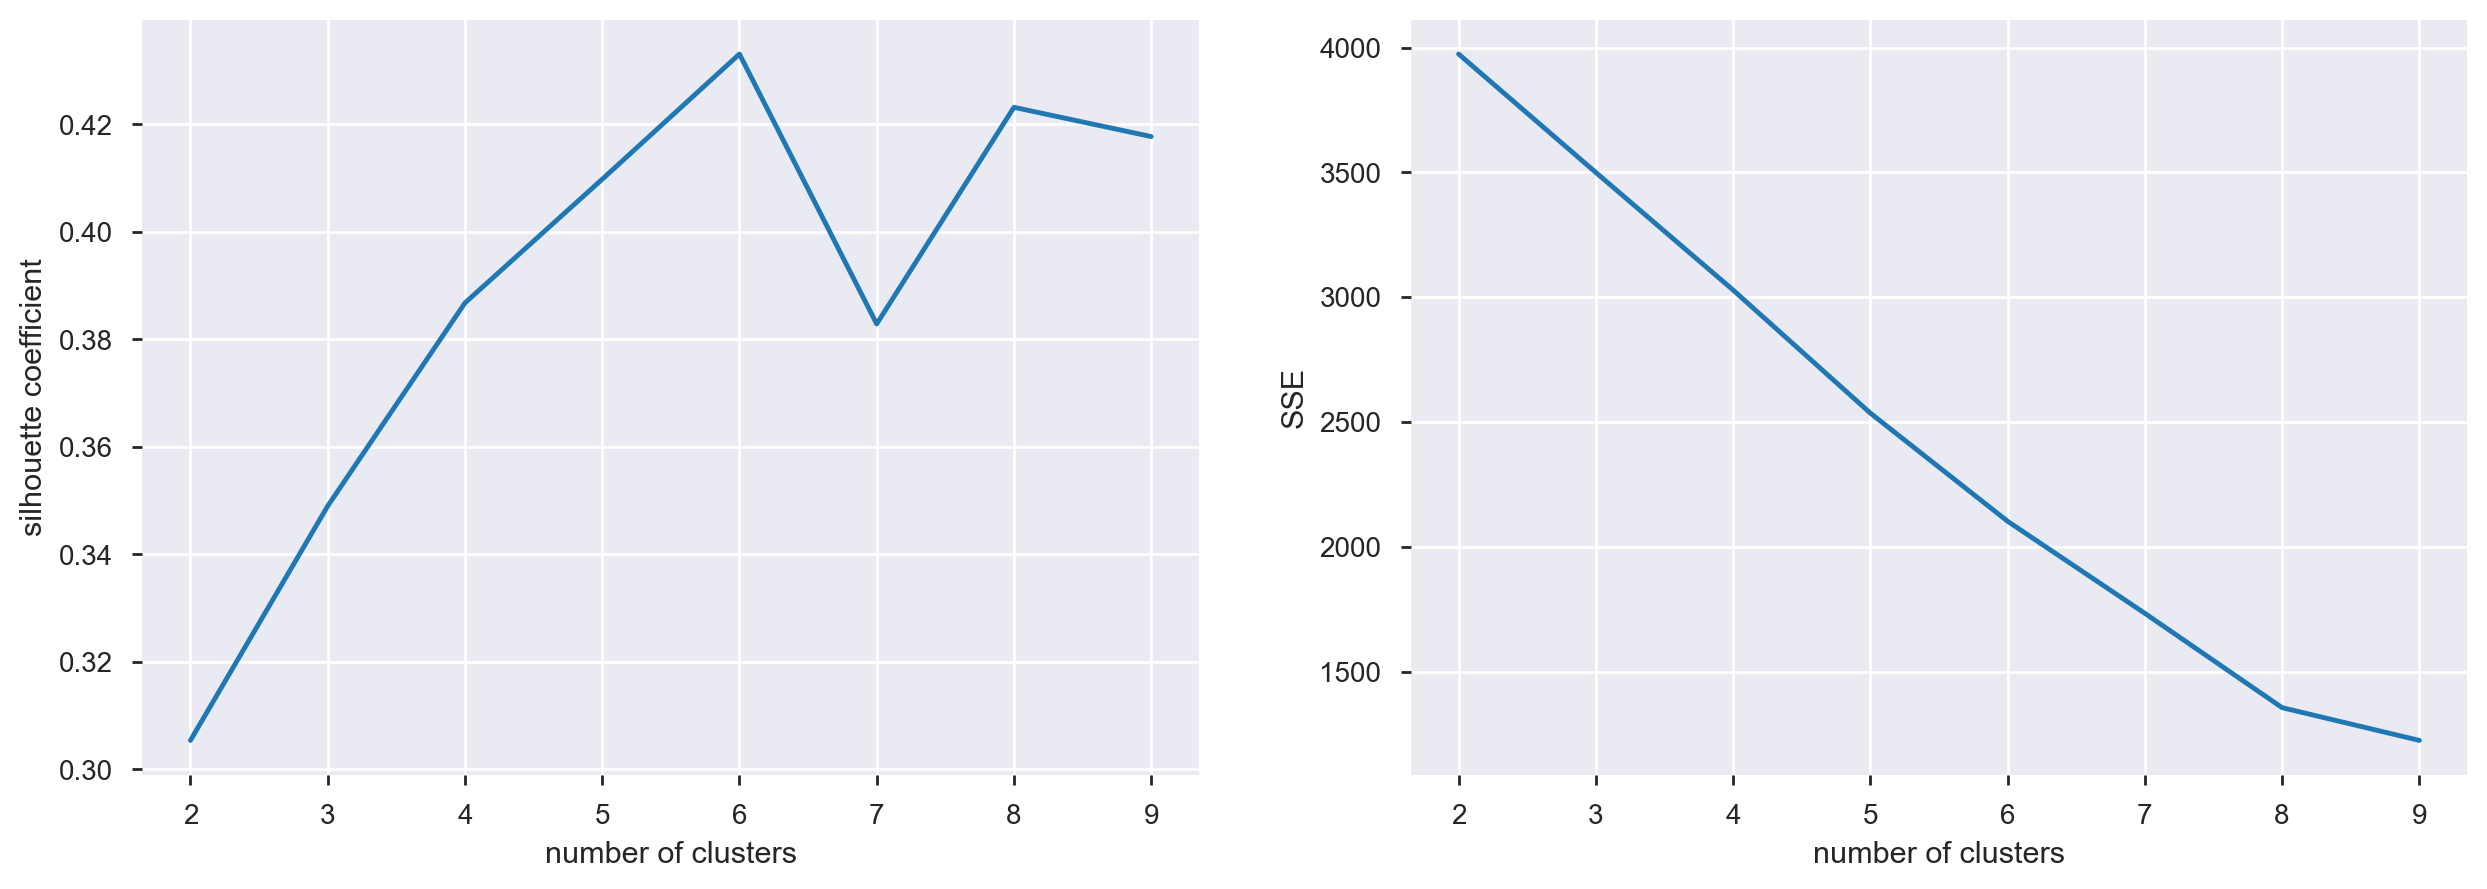

In [297]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [298]:
inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(nmf_tfidf_data_scaled)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  2   Inertia: 3974.214701


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  3   Inertia: 3438.901885


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  4   Inertia: 2928.414273


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  5   Inertia: 2529.483623


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  6   Inertia: 2095.053077


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  7   Inertia: 1734.564684


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  8   Inertia: 1356.422797


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters:  9   Inertia: 1224.461771


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 10   Inertia: 1113.470803


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 11   Inertia: 1022.862192


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 12   Inertia: 943.340985


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 13   Inertia: 871.000227


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=14, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 14   Inertia: 799.784603


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 15   Inertia: 779.629328


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 16   Inertia: 714.396087


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=17, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 17   Inertia: 667.103553


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=18, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 18   Inertia: 638.752295


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=19, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 19   Inertia: 612.053039


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 20   Inertia: 591.367643


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=21, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 21   Inertia: 568.438295


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=22, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 22   Inertia: 550.665176


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=23, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 23   Inertia: 523.384805


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=24, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# clusters: 24   Inertia: 502.073954


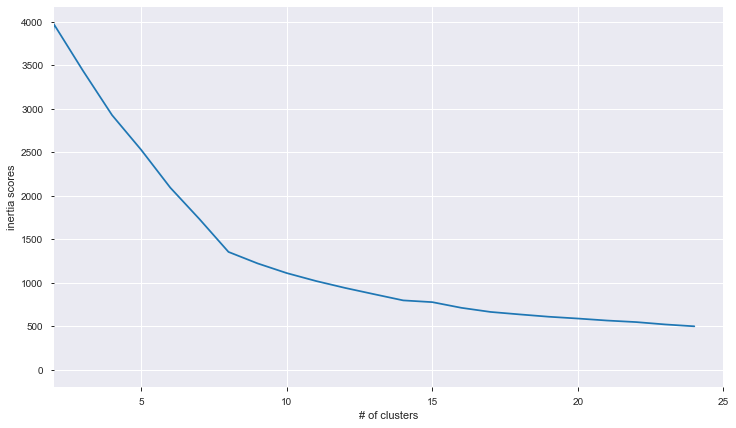

In [301]:
plt.figure(figsize=(12,7))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores');

In [307]:
# running cluster
k = 8
kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(nmf_tfidf_data_scaled)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = tfidf_vectorizer.get_feature_names()

for i in range(0,k):
    word_list=[]
    print("cluster%d:"% i)
    for j in centers[i,:15]:
        word_list.append(terms[j])
    print(word_list)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

cluster0:
['absolutely love', 'accept', 'act', 'action', 'accommodate', 'able', 'absolutely']
cluster1:
['accommodate', 'absolutely love', 'accept', 'action', 'able', 'absolutely', 'act']
cluster2:
['able', 'act', 'accept', 'accommodate', 'action', 'absolutely', 'absolutely love']
cluster3:
['action', 'act', 'accommodate', 'accept', 'able', 'absolutely', 'absolutely love']
cluster4:
['absolutely', 'act', 'accept', 'accommodate', 'action', 'able', 'absolutely love']
cluster5:
['accommodate', 'absolutely', 'able', 'action', 'act', 'accept', 'absolutely love']
cluster6:
['accept', 'action', 'accommodate', 'able', 'absolutely', 'act', 'absolutely love']
cluster7:
['act', 'accommodate', 'action', 'absolutely love', 'accept', 'able', 'absolutely']


[t-SNE] Computing 277 nearest neighbors...
[t-SNE] Indexed 646 samples in 0.000s...
[t-SNE] Computed neighbors for 646 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 646 / 646
[t-SNE] Mean sigma: 0.543158
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.654224
[t-SNE] KL divergence after 300 iterations: 0.444644


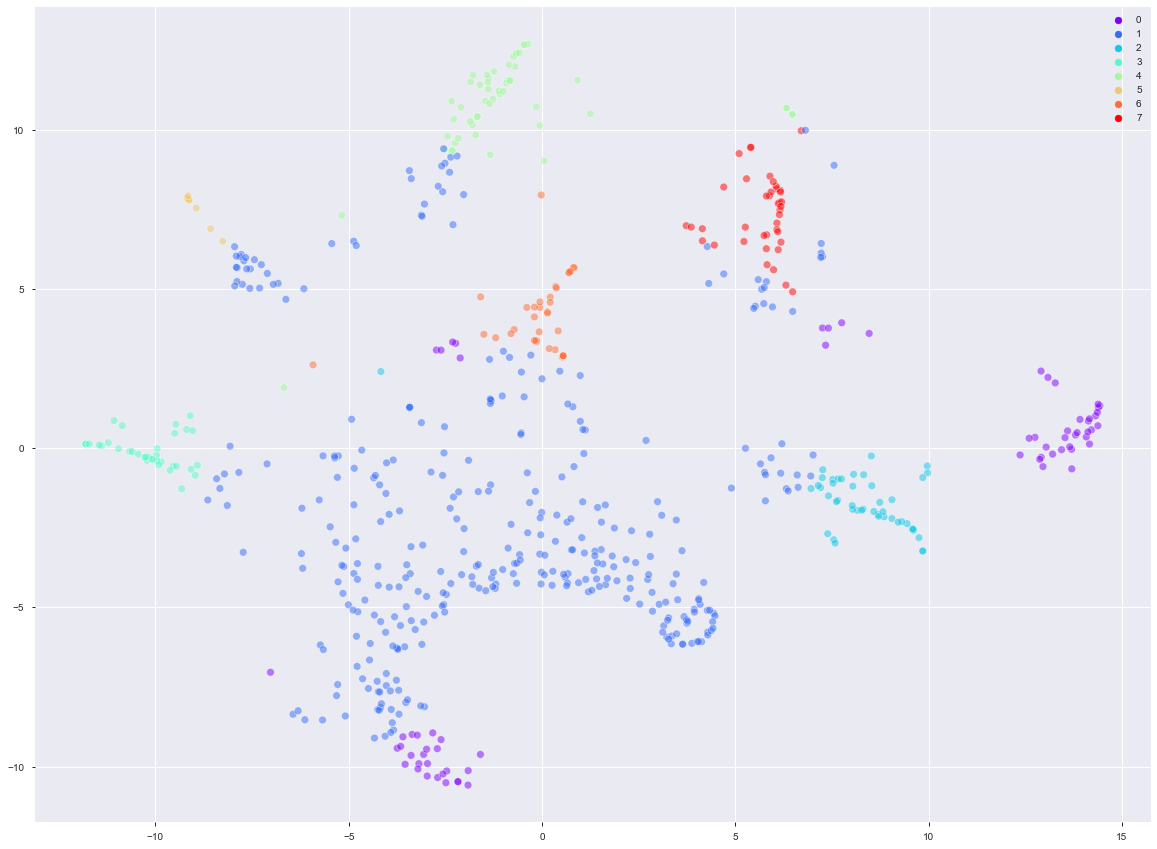

In [308]:
tsne = TSNE(n_components=2, verbose=1, perplexity=92, n_iter=300)
X_ne = tsne.fit_transform(nmf_tfidf_data_scaled)

plt.figure(figsize=(20,15))
sns.scatterplot(X_ne[:, 0], X_ne[:, 1], hue=kmeans.labels_, alpha=0.5, s = 60, palette='rainbow', legend='full');

In [366]:
import umap

In [367]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(reviews.tidy_reviews)

AttributeError: module 'umap' has no attribute 'UMAP'